In [10]:
import pandas as pd
import requests
import matplotlib.pyplot as plt 

In [11]:
#read in observed active layer thickness observations from CALM "Imnavait Creek WET" site (U11B)
#see the repo metadata here: https://arcticdata.io/catalog/view/doi%3A10.18739%2FA2SF2MD3T
#and here: https://www2.gwu.edu/~calm/data/north.htm
#grid is located at 68.611, -149.3145
#note, this data has been cleaned and reorganized into a tidy format for this analysis
# the dataset covers years 1995-2015 and includes only the last ALT observation of each season (max thaw)
#data_URL = "https://arcticdata.io/metacat/d1/mn/v2/object/urn%3Auuid%3Ac18cb8a7-c9de-4126-8411-dcbcde63c09d"
u11b = pd.read_csv('./calm_u11b.csv')
u11b['DATE'] = pd.to_datetime(u11b['DATE'])
u11b.head()

,DATE,MEAN_ALT_CM,STDEV,MIN_ALT_CM,MAX_ALT_CM
0,1995-08-20,52.96,8.93,29.0,71.0
1,1996-08-20,54.13,9.63,29.0,81.0
2,1997-08-09,56.42,7.75,38.0,74.0
3,1998-08-13,54.46,7.79,39.0,81.0
4,1999-08-10,53.22,8.66,34.0,84.0


In [12]:
#add columns to hold temperature data
u11b["MEAN_AUG_TEMP"] = ""

In [13]:
#now query some climate data using the site location and the SNAP Data API
#we will use the API to access the CRU-TS 4.0 data: https://catalog.snap.uaf.edu/geonetwork/srv/api/records/3b2b24ff-4916-4d92-95b7-c6b2fcefd381
#we are interested in August temps, so we will subset the query to just get August in the years matching our dataset:
lat = "69.401"
lon = "-148.8056"

start_year = 1995
end_year = 2015

url = str("https://earthmaps.io/tas2km/point/" + lat + "/" + lon)
with requests.Session() as s:
    temp_response = s.get(url)
    if temp_response.status_code != 200:
            print("Bad request ...  coordinates may be out of bounds.")
    else:
        #pull just the 1995-2015 historical data into its own dictionary
        aug_temps = {}
        for year in range(start_year, end_year+1):
            aug_temps[str(year)] = temp_response.json()["historical"]['CRU-TS']['historical']['August'][str(year)]['tasmean']

In [14]:
for index, row in u11b.iterrows():
    year_key = str(row.DATE.year)
    u11b.loc[index, "MEAN_AUG_TEMP"] = aug_temps[year_key]

In [15]:
u11b.head()

,DATE,MEAN_ALT_CM,STDEV,MIN_ALT_CM,MAX_ALT_CM,MEAN_AUG_TEMP
0,1995-08-20,52.96,8.93,29.0,71.0,9.7
1,1996-08-20,54.13,9.63,29.0,81.0,8.3
2,1997-08-09,56.42,7.75,38.0,74.0,11.7
3,1998-08-13,54.46,7.79,39.0,81.0,11.8
4,1999-08-10,53.22,8.66,34.0,84.0,12.6


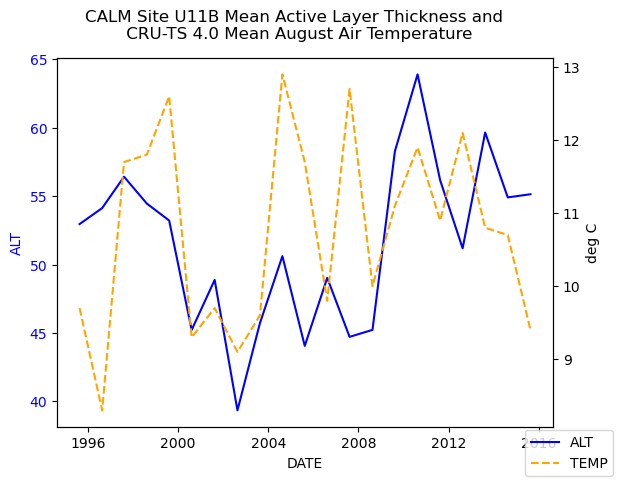

In [17]:
#plot the data to explore relationships

x = u11b['DATE']
y1 = u11b['MEAN_ALT_CM'].astype(float)
y2 = u11b['MEAN_AUG_TEMP'].astype(float)

fig, ax1 = plt.subplots()

ax1.set_xlabel('DATE')
ax1.set_ylabel('ALT', color='blue')
ax1.plot(x, y1, color='blue', label='ALT')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx() 
ax2.set_ylabel('deg C')
ax2.plot(x, y2, color='orange', label="TEMP", linestyle='dashed')
ax2.tick_params(axis='y')

fig.legend(loc='lower right')
fig.suptitle("CALM Site U11B Mean Active Layer Thickness and \n CRU-TS 4.0 Mean August Air Temperature")
plt.show()